# Deep Learning - Final Project


## Deep Learning Based Pneumonia Detection
### Project Objective
Chest X-rays are widely used in clinical practice, being cheap and easy to perform, and having a wide range of uses in the diagnosis and treatment of lung and cardiovascular disease. As the number of radiologists who interpret these photos is limited, the number of chest X-rays increases rapidly. Our project goal is to show that DL tools can be used in order to assist in the detection, improve and take some of the load caused in the process of Pneumonia diagnosis, and help give better and faster treatment to the patients & improve the whole decoder system.

Further Motivation for our project can be found in these articles: 
* Moses, Daniel A. "Deep learning applied to automatic disease detection using chest X‐rays." Journal of Medical Imaging and Radiation Oncology 65.5 (2021): 498-517.
 https://onlinelibrary.wiley.com/doi/10.1111/1754-9485.13273
* "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning" https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

### The Database

Our database consists of 5,863 X-Ray images organized into 3 folders (train, test, val) containing subfolders for each image category (Pneumonia/Normal).

The database can be downloaded from here: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

The chest X-ray images in this dataset were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

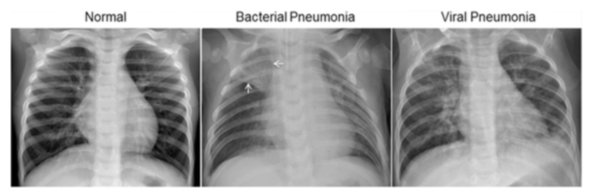

> The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

### Import google drive and librairies

Drive mount: (where we store the datas and where we will save our model)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Move to our drive folder as root directory

In [2]:
%cd drive/MyDrive

/content/drive/MyDrive


Import torch libraries, tqdm, PIL matplotlib, numpy and pandas

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import os
import PIL.Image as Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torch.autograd import Variable
from tqdm.notebook import tqdm
import os, os.path
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# import cv2

In [4]:
def count_files(dir): # dir is your directory path
  return len(os.listdir(dir))

Normal:  8
Pneumonia:  8


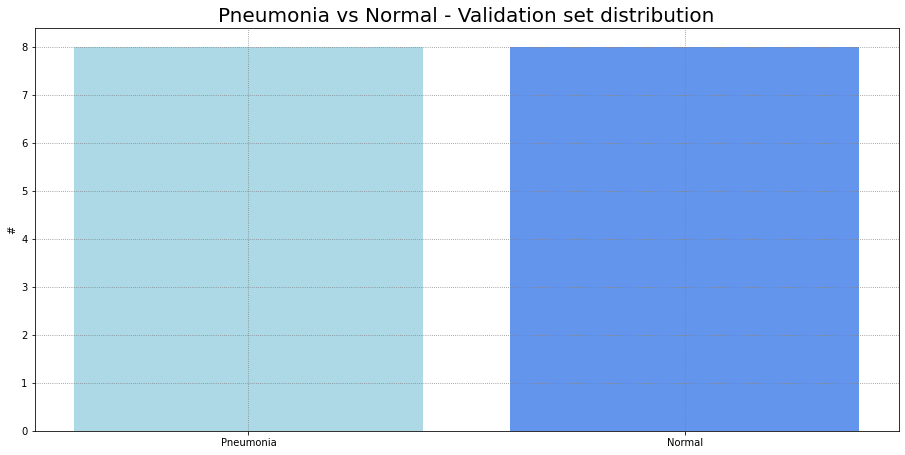

In [5]:
# Pneumonia vs Normal - Validating Set Patients' Distribution

dir = '/content/drive/MyDrive/chest_xray/val/NORMAL'
number_files_normal = count_files(dir)

dir = '/content/drive/MyDrive/chest_xray/val/PNEUMONIA'
number_files_pneumonia = count_files(dir)

print("Normal: ", number_files_normal)
print("Pneumonia: ", number_files_pneumonia)

normal_counter = number_files_normal
pneumonia_counter = number_files_pneumonia

fig = plt.figure(figsize=(15,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.bar(['Pneumonia',
         'Normal'], [number_files_pneumonia, number_files_normal],
        color = ["lightblue","cornflowerblue"])
plt.grid(linestyle=":", color='grey')
plt.title('Pneumonia vs Normal - Validation set distribution', fontsize =20)
plt.ylabel('#')
plt.show()

Normal:  1341
Pneumonia:  3875


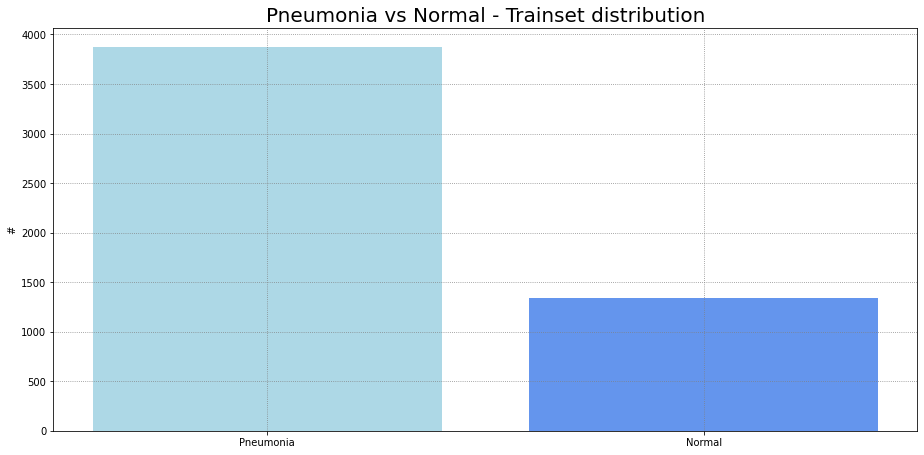

In [6]:
# Pneumonia vs Normal - Training Set Patients' Distribution
dir = '/content/drive/MyDrive/chest_xray/train/NORMAL'
number_files_normal = count_files(dir)

dir = '/content/drive/MyDrive/chest_xray/train/PNEUMONIA'
number_files_pneumonia = count_files(dir)

print("Normal: ", number_files_normal)
print("Pneumonia: ", number_files_pneumonia)

normal_counter += number_files_normal
pneumonia_counter += number_files_pneumonia

fig = plt.figure(figsize=(15,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.bar(['Pneumonia',
         'Normal'], [number_files_pneumonia, number_files_normal],
        color = ["lightblue","cornflowerblue"])
plt.grid(linestyle=":", color='grey')
plt.title('Pneumonia vs Normal - Trainset distribution', fontsize =20)
plt.ylabel('#')
plt.show()

Normal:  234
Pneumonia:  390


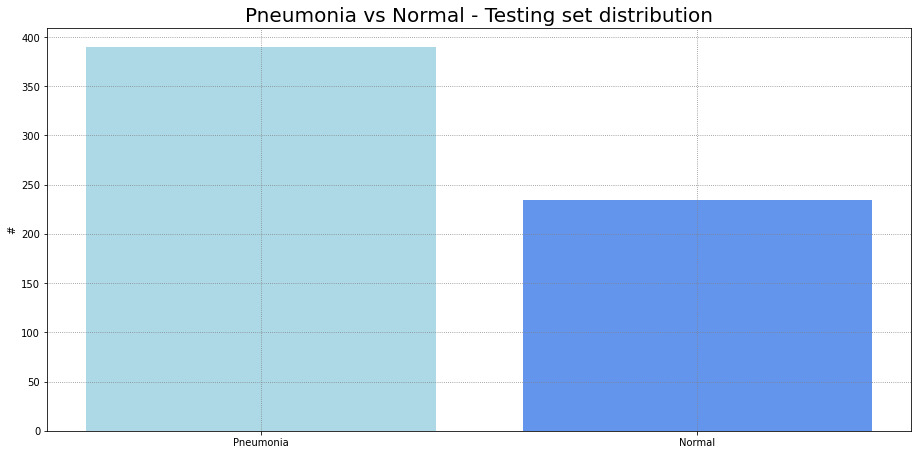

In [7]:
# Pneumonia vs Normal - Testing Set Patients' Distribution

dir = '/content/drive/MyDrive/chest_xray/test/NORMAL'
number_files_normal = count_files(dir)

dir = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA'
number_files_pneumonia = count_files(dir)

print("Normal: ", number_files_normal)
print("Pneumonia: ", number_files_pneumonia)

normal_counter += number_files_normal
pneumonia_counter += number_files_pneumonia

fig = plt.figure(figsize=(15,7))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.bar(['Pneumonia',
         'Normal'], [number_files_pneumonia, number_files_normal],
        color = ["lightblue","cornflowerblue"])
plt.grid(linestyle=":", color='grey')
plt.title('Pneumonia vs Normal - Testing set distribution', fontsize =20)
plt.ylabel('#')
plt.show()

In [8]:
print("Total number of Pneumonia photos: %f " % pneumonia_counter)
print("Total number of Normal photos: %f " % normal_counter)


Total number of Pneumonia photos: 4273.000000 
Total number of Normal photos: 1583.000000 


In [9]:
# (398+3875)/5863

We can observe that about 70% of our data is labeled 'Pneumonia', more than double of the pictures labeled 'Normal'

## Modeling
#### Modeling Approach:
- compare pretrained models to non-pretrained models
- comparing multiple models
- select the best model

### Build the dataloaders in torch
First we build the transformation that will be apply to our images:


1.   First a resize to (256x256x3) to fit the pretrained model on image net we will use.
2.   For the training some random data augmentation (rotation, horizontal,flip)

3. Then we will convert our images to tensor

4. To conclude we will normalize them by the mean and the variance that was used to pretrain the model.



In [10]:
train_transforms = transforms.Compose([ #data augmentation and normalization for the training set
    transforms.Resize((256,256)),
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) 
])

test_transforms = transforms.Compose([ #normalisation of the data for the testing set                            
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])


We will now load our data using torch DataLoader, by applying also the transofrmation we define earlier. We will use the train test val split provided by the dataset to make the experiment reproducible and able to used in benchmark.

In [11]:
train_loader = torch.utils.data.DataLoader(
    
   datasets.ImageFolder("chest_xray/train" ,
                        transform=train_transforms),
   batch_size=32, shuffle=True, num_workers=1)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder("chest_xray/val",
                         transform=test_transforms),
    batch_size=32, shuffle=True, num_workers=1)

test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder("chest_xray/test",
                         transform=test_transforms),
    batch_size=5, shuffle=True, num_workers=1) # we had to lower the batch_size to reduce GPU ram usage.

# 1st Model: resnet101 - pretrained vs. non-pretrained

## Training

Lets check if gpu is available and create the folder where we will store our models after each epochs

In [12]:
#boolean to know if gpu is available
use_cuda = torch.cuda.is_available()

# Create experiment folder
if not os.path.isdir("best_models"):
    os.makedirs("best_models")


In [13]:
#Training 

#boolean to know if gpu is available
use_cuda = torch.cuda.is_available()


# Create experiment folder
if not os.path.isdir("best_models_not_pretrained"):
    os.makedirs("best_models_not_pretrained")


We will use SGD optimizer with a 1e-3 learning rate and momentum of 0.9.
And perform the training. At the end of each epochs, if the validation loss is the lowest we have seen in the training, then we will keep track of the epoch number to be able to load the weigths after this epoch later.


In [14]:
def train(epoch, model):  #the train for a single epoch
    model.train() 
    for batch_idx, (data, target) in enumerate(train_loader): #for each batch
        if use_cuda: #if cuda available, move the data and target to gpu
            data, target = data.cuda(), target.cuda()
        target = target.reshape(-1,1)
        data = data.float()
        target = target.float()
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.BCEWithLogitsLoss(weight=None,reduction='mean') #We decide to use cross entropy loss for classification
        loss = criterion(output, target) #calculate the loss
        loss.backward() #do the backpropagation
        optimizer.step()
        if batch_idx % 50 == 0: #We print the results 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item())) 

def validation(model): #the evaluation of the val dataset
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader: #for each data target in the data loader
        if use_cuda: #if gpu is available, we move the data and target to gpu
            data, target = data.cuda(), target.cuda()
        target = target.reshape(-1,1)
        data = data.float()
        target = target.float()
        output = model(data) 
        # sum up batch loss
        criterion = torch.nn.BCEWithLogitsLoss(weight=None,reduction='mean')
        validation_loss += criterion(output, target).data.item() #compute the loss
        # get the index of the max log-probability
        correct += np.array(((1 * (output>0) == target)).cpu()).sum() #add +1 if the prediction is correct otherwise 0

    validation_loss /= len(val_loader.dataset) #calculate the loss
    #print the loss and the precision of the test set
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return validation_loss


### Pretrained resnet101

We will use a pretrained Resnet101 on IMAGENET to accelerate the training, and we will use 20 epochs.

In [15]:
number_epoch = 20 #number of epochs

We will change the last fully connected layer to a linear layer with an output of size (Batch_size,1) to match our binary classification task.

In [16]:
#importation of a pretrained resnet101 and change the last fully connected layer to adapt it for the classification
model1 = models.resnet101(pretrained=True)
num_features = model1.fc.in_features
model1.fc = nn.Linear(num_features,1)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

In [17]:
#Training 

#boolean to know if gpu is available
use_cuda = torch.cuda.is_available()


# Create experiment folder
if not os.path.isdir("best_models_resnet101"):
    os.makedirs("best_models_resnet101")


In [18]:
%%time
if use_cuda: #if gpu available, we move the model to gpu
    print('Using GPU')
    model1.cuda()
    
else:
    print('Using CPU')

optimizer = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9) #We will use a SGD for optimizer

lr = 0.001
best_loss = np.inf
best_epoch = 0
for epoch in range(1, number_epoch + 1): #for each epoch
    optimizer = optim.SGD(model1.parameters(), lr, momentum=0.9) #initialise the optimizer 
    train(epoch,model1) #do the training of the epoch
    validation_loss = validation(model1) #and the validation 
    if best_loss > validation_loss:
        best_epoch = epoch
        best_loss = validation_loss
    model_file = 'best_models_resnet101' + '/model_' + str(epoch) + '.pth' 
    torch.save(model1.state_dict(), model_file) #save the weight of the model
    #lr = adjust_learning_rate(epoch) #adjust the learning rate
    print('Saved model to ' + model_file )
print('best epoch : {}'.format(best_epoch))

Using GPU
Train Epoch: 1 [0/5216 (0%)]	Loss: 0.698099
Train Epoch: 1 [1600/5216 (31%)]	Loss: 0.208806
Train Epoch: 1 [3200/5216 (61%)]	Loss: 0.065622
Train Epoch: 1 [4800/5216 (92%)]	Loss: 0.108677

Validation set: Average loss: 0.0403, Accuracy: 10/16 (62%)
Saved model to best_models_resnet101/model_1.pth
Train Epoch: 2 [0/5216 (0%)]	Loss: 0.079008
Train Epoch: 2 [1600/5216 (31%)]	Loss: 0.097013
Train Epoch: 2 [3200/5216 (61%)]	Loss: 0.150425
Train Epoch: 2 [4800/5216 (92%)]	Loss: 0.046880

Validation set: Average loss: 0.0194, Accuracy: 14/16 (88%)
Saved model to best_models_resnet101/model_2.pth
Train Epoch: 3 [0/5216 (0%)]	Loss: 0.062019
Train Epoch: 3 [1600/5216 (31%)]	Loss: 0.068754
Train Epoch: 3 [3200/5216 (61%)]	Loss: 0.092147
Train Epoch: 3 [4800/5216 (92%)]	Loss: 0.017189

Validation set: Average loss: 0.0268, Accuracy: 12/16 (75%)
Saved model to best_models_resnet101/model_3.pth
Train Epoch: 4 [0/5216 (0%)]	Loss: 0.054910
Train Epoch: 4 [1600/5216 (31%)]	Loss: 0.074584
Trai

#### Load the best model

We first find the path of the best weigths

In [19]:
#Loading our best model from resnet101
weight_path_model2 = "best_models_resnet101/model_{}.pth".format(best_epoch) #put the path of the weight

Then we load them into our model

In [20]:
state_dict1 = torch.load(weight_path_model2)
model1.load_state_dict(state_dict1)


<All keys matched successfully>

We will compute the test loss and the accuracy over the test set

In [21]:
use_cuda = torch.cuda.is_available()
if use_cuda: #if gpu available, we move the model to gpu
    print('Using GPU')
    model1.cuda()

model1.eval()
test_loss = 0
correct = 0
all_pred = []
all_labels = []
for data, target in tqdm(test_loader): #for each data target in the data loader
    if use_cuda: #if gpu is available, we move the data and target to gpu
        data, target = data.cuda(), target.cuda()
    target = target.reshape(-1,1)
    data = data.float()
    target = target.float()
    output = model1(data) 
    # sum up batch loss
    criterion = torch.nn.BCEWithLogitsLoss(weight=None,reduction='mean')
    test_loss += criterion(output, target).data.item() #compute the loss
    # get the index of the max log-probability
    correct += np.array(((1 * (output>0) == target)).cpu()).sum() #add +1 if the prediction is correct otherwise 0
    all_pred += list((1 * (output>0).cpu().numpy()).reshape(-1))
    all_labels += list((target.cpu().numpy()).reshape(-1))
test_loss /= len(test_loader.dataset) #calculate the loss
#print the loss and the precision of the test set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Using GPU


  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 582/624 (93%)


And build our confusion matrix

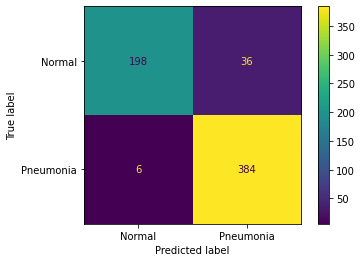

In [22]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay
cm2 = confusion_matrix(np.array(all_labels), np.array(all_pred))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=['Normal','Pneumonia'])
disp2.plot()


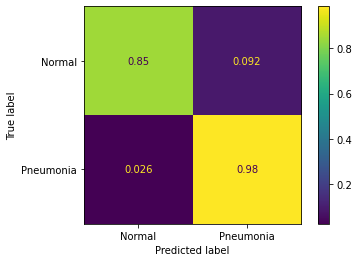

In [23]:
C2 = cm2 / cm2.astype(float).sum(axis=1)
disp3 = ConfusionMatrixDisplay(confusion_matrix=C2,display_labels=['Normal','Pneumonia'])

disp3.plot()

### Not pretrained model 

In [24]:
number_epoch = 20 #number of epochs
#importation of a pretrained resnet101 and change the last fully connected layer to adapt it for the classification
model4 = models.resnet101(pretrained=False)
num_features = model4.fc.in_features
model4.fc = nn.Linear(num_features,1)

In [25]:
%%time
if use_cuda: #if gpu available, we move the model to gpu
    print('Using GPU')
    model4.cuda()
    
else:
    print('Using CPU')

optimizer = optim.SGD(model4.parameters(), lr=0.001, momentum=0.9) #We will use a SGD for optimizer

lr = 0.001
best_loss = np.inf
best_epoch = 0
for epoch in range(1, number_epoch + 1): #for each epoch
    optimizer = optim.SGD(model4.parameters(), lr, momentum=0.9) #initialise the optimizer 
    train(epoch,model4) #do the training of the epoch
    validation_loss = validation(model4) #and the validation 
    if best_loss > validation_loss:
      best_epoch = epoch
      best_loss = validation_loss
    model_file = 'best_models_not_pretrained' + '/model_' + str(epoch) + '.pth' 
    torch.save(model4.state_dict(), model_file) #save the weight of the model
    #lr = adjust_learning_rate(epoch) #adjust the learning rate
    print('Saved model to ' + model_file )
print('best epoch : {}'.format(best_epoch))

Using GPU
Train Epoch: 1 [0/5216 (0%)]	Loss: 0.738497
Train Epoch: 1 [1600/5216 (31%)]	Loss: 0.481307
Train Epoch: 1 [3200/5216 (61%)]	Loss: 0.525597
Train Epoch: 1 [4800/5216 (92%)]	Loss: 0.804819

Validation set: Average loss: 0.0473, Accuracy: 10/16 (62%)
Saved model to best_models_not_pretrained/model_1.pth
Train Epoch: 2 [0/5216 (0%)]	Loss: 0.443257
Train Epoch: 2 [1600/5216 (31%)]	Loss: 0.353858
Train Epoch: 2 [3200/5216 (61%)]	Loss: 0.679355
Train Epoch: 2 [4800/5216 (92%)]	Loss: 0.403961

Validation set: Average loss: 0.0371, Accuracy: 10/16 (62%)
Saved model to best_models_not_pretrained/model_2.pth
Train Epoch: 3 [0/5216 (0%)]	Loss: 0.417129
Train Epoch: 3 [1600/5216 (31%)]	Loss: 0.245244
Train Epoch: 3 [3200/5216 (61%)]	Loss: 0.149334
Train Epoch: 3 [4800/5216 (92%)]	Loss: 0.316534

Validation set: Average loss: 0.0548, Accuracy: 9/16 (56%)
Saved model to best_models_not_pretrained/model_3.pth
Train Epoch: 4 [0/5216 (0%)]	Loss: 0.323650
Train Epoch: 4 [1600/5216 (31%)]	Loss:

In [26]:
use_cuda = torch.cuda.is_available()
if use_cuda: #if gpu available, we move the model to gpu
    print('Using GPU')
    model4.cuda()

model4.eval()
test_loss = 0
correct = 0
all_pred = []
all_labels = []
for data, target in tqdm(test_loader): #for each data target in the data loader
    if use_cuda: #if gpu is available, we move the data and target to gpu
        data, target = data.cuda(), target.cuda()
    target = target.reshape(-1,1)
    data = data.float()
    target = target.float()
    output = model4(data) 
    # sum up batch loss
    criterion = torch.nn.BCEWithLogitsLoss(weight=None,reduction='mean')
    test_loss += criterion(output, target).data.item() #compute the loss
    # get the index of the max log-probability
    correct += np.array(((1 * (output>0) == target)).cpu()).sum() #add +1 if the prediction is correct otherwise 0
    all_pred += list((1 * (output>0).cpu().numpy()).reshape(-1))
    all_labels += list((target.cpu().numpy()).reshape(-1))
test_loss /= len(test_loader.dataset) #calculate the loss
#print the loss and the precision of the test set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Using GPU


  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.1322, Accuracy: 509/624 (82%)


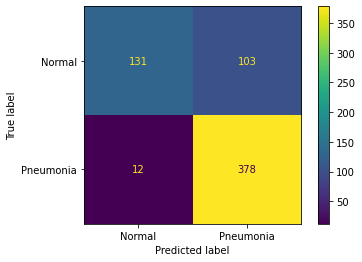

In [27]:

cm5 = confusion_matrix(np.array(all_labels), np.array(all_pred))
disp6 = ConfusionMatrixDisplay(confusion_matrix=cm5,display_labels=['Normal','Pneumonia'])
disp6.plot()

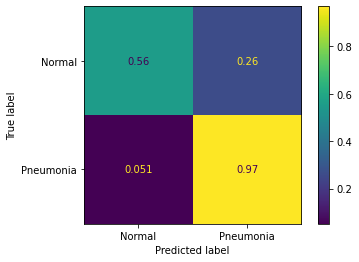

In [28]:
C5 = cm5 / cm5.astype(float).sum(axis=1)
disp7 = ConfusionMatrixDisplay(confusion_matrix=C5,display_labels=['Normal','Pneumonia'])

disp7.plot()

### Comparing Pretrained vs Non.

In [29]:
def dir_list_models(dir="best_models", n=20):  # creates a list of n_epochs=20 models for a given directory
    models_list = []
    for i in range(n):
        tmp = dir + "/model_" + str(i+1) +".pth"
        models_list.append(tmp)
    return models_list

def create_log_data(model, models_list): # given a trained model and list returns a unified df of [Acc, avg.loss, epoch#]
    epoch_avg_loss = []
    epoch_test_acc = []
    num=1

    for weight_path in models_list:
        state_dict = torch.load(weight_path)
        model.load_state_dict(state_dict)
        use_cuda = torch.cuda.is_available()
        if use_cuda: #if gpu available, we move the model to gpu
            print('Using GPU')
            model.cuda()

            model.eval()
            test_loss = 0
            correct = 0
            for data, target in tqdm(test_loader): #for each data target in the data loader
                if use_cuda: #if gpu is available, we move the data and target to gpu
                    data, target = data.cuda(), target.cuda()
                target = target.reshape(-1,1)
                data = data.float()
                target = target.float()
                output = model(data) 
                # sum up batch loss
                criterion = torch.nn.BCEWithLogitsLoss(weight=None,reduction='mean')
                test_loss += criterion(output, target).data.item() #compute the loss
                # get the index of the max log-probability
                correct += np.array(((1 * (output>0) == target)).cpu()).sum() #add +1 if the prediction is correct otherwise 0
            test_loss /= len(test_loader.dataset) #calculate the loss
            #print the loss and the precision of the test set
            print('\nEpoch: {}, Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                num,test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))
            
            epoch_test_acc.append(100. * correct / len(test_loader.dataset))
            epoch_avg_loss.append(test_loss)
            num+=1
    epoch = []
    for i in range(20):
        epoch.append(i+1)

    log_data = pd.DataFrame(epoch_avg_loss,epoch_test_acc)
    log_data = log_data.reset_index()
    log_data.columns = ['Accuracy', 'Avg.Loss']
    log_data['epoch'] = epoch

    return log_data

In [ ]:
%%time
models_list1 = dir_list_models(dir="best_models_resnet101")
logdata_model1 = create_log_data(model=model1, models_list=models_list1)

In [ ]:
%%time
models_list4 = dir_list_models(dir="best_models_not_pretrained")
logdata_model4 = create_log_data(model=model4, models_list=models_list4)

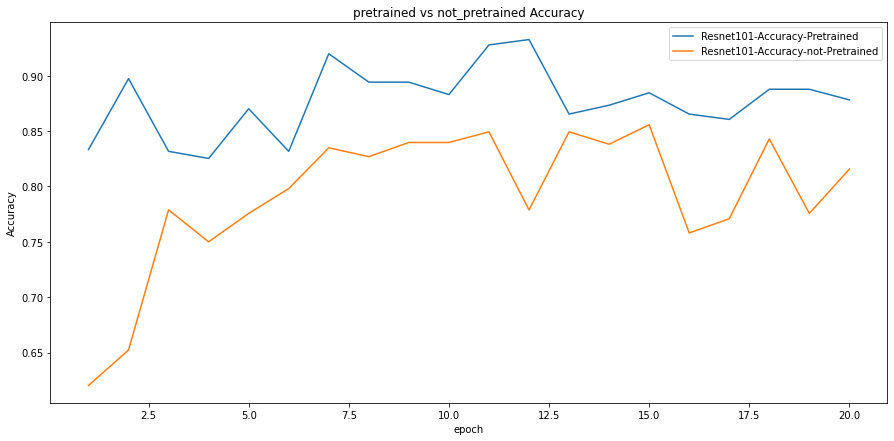

In [32]:
plt.figure(figsize=(15,7))
plt.plot(logdata_model1.epoch, logdata_model1.Accuracy/100, label='Resnet101-Accuracy-Pretrained')
plt.plot(logdata_model4.epoch, logdata_model4.Accuracy/100, label='Resnet101-Accuracy-not-Pretrained')


# plt.plot(log_data.epoch, log_data.validate_accuracy, label='validation')
# plt.plot(log_data.epoch, test_accuracy1*np.ones(log_data1.epoch.shape), label=f'test: {test_accuracy1*100:2.2f}%')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('Accuracy');  plt.title('pretrained vs not_pretrained Accuracy');

plt.show()

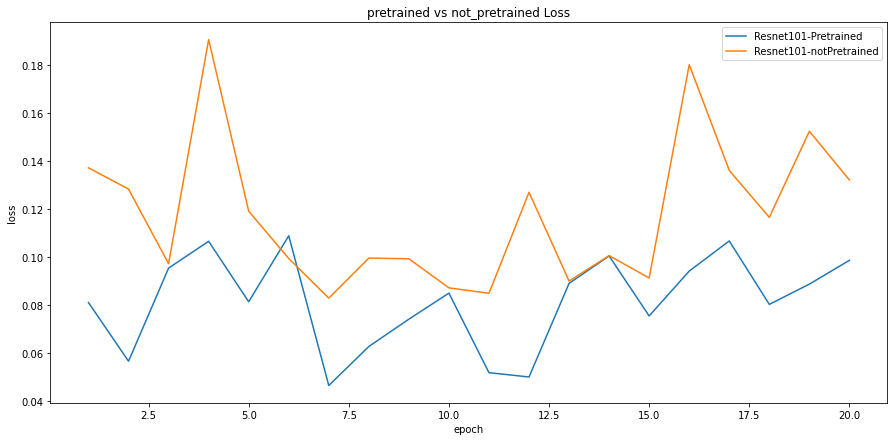

In [33]:
plt.figure(figsize=(15,7))
plt.plot(logdata_model1.epoch, logdata_model1['Avg.Loss'], label='Resnet101-Pretrained')
plt.plot(logdata_model4.epoch, logdata_model4['Avg.Loss'], label='Resnet101-notPretrained')


# plt.plot(log_data.epoch, log_data.validate_accuracy, label='validation')
# plt.plot(log_data.epoch, test_accuracy1*np.ones(log_data1.epoch.shape), label=f'test: {test_accuracy1*100:2.2f}%')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('loss');  plt.title('pretrained vs not_pretrained Loss');

plt.show()

#### We've decided to continue with pretrained models.

### Second Model : pretrained model : resnet18

In [34]:
pretrained = True
number_epoch = 20 #number of epochs

In [35]:
#importation of a pretrained resnet18 and change the last fully connected layer to adapt it for the classification
model = models.resnet18(pretrained=pretrained)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features,1)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [36]:
%%time
if use_cuda: #if gpu available, we move the model to gpu
    print('Using GPU')
    model.cuda()
    
else:
    print('Using CPU')

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #We will use a SGD for optimizer


lr = 0.001
best_loss = np.inf
best_epoch = 0
for epoch in range(1, number_epoch + 1): #for each epoch
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9) #initialise the optimizer 
    train(epoch, model) #do the training of the epoch
    validation_loss = validation(model) #and the validation 
    if best_loss > validation_loss:
      best_epoch = epoch
      best_loss = validation_loss
    model_file = 'best_models' + '/model_' + str(epoch) + '.pth' 
    torch.save(model.state_dict(), model_file) #save the weight of the model
    #lr = adjust_learning_rate(epoch) #adjust the learning rate
    print('Saved model to ' + model_file )
print('best epoch : {}'.format(best_epoch))

Using GPU
Train Epoch: 1 [0/5216 (0%)]	Loss: 0.670239
Train Epoch: 1 [1600/5216 (31%)]	Loss: 0.127963
Train Epoch: 1 [3200/5216 (61%)]	Loss: 0.060282
Train Epoch: 1 [4800/5216 (92%)]	Loss: 0.083111

Validation set: Average loss: 0.0512, Accuracy: 10/16 (62%)
Saved model to best_models/model_1.pth
Train Epoch: 2 [0/5216 (0%)]	Loss: 0.106039
Train Epoch: 2 [1600/5216 (31%)]	Loss: 0.032847
Train Epoch: 2 [3200/5216 (61%)]	Loss: 0.097019
Train Epoch: 2 [4800/5216 (92%)]	Loss: 0.114490

Validation set: Average loss: 0.0350, Accuracy: 12/16 (75%)
Saved model to best_models/model_2.pth
Train Epoch: 3 [0/5216 (0%)]	Loss: 0.101552
Train Epoch: 3 [1600/5216 (31%)]	Loss: 0.112924
Train Epoch: 3 [3200/5216 (61%)]	Loss: 0.023905
Train Epoch: 3 [4800/5216 (92%)]	Loss: 0.123690

Validation set: Average loss: 0.0092, Accuracy: 15/16 (94%)
Saved model to best_models/model_3.pth
Train Epoch: 4 [0/5216 (0%)]	Loss: 0.324607
Train Epoch: 4 [1600/5216 (31%)]	Loss: 0.049972
Train Epoch: 4 [3200/5216 (61%)]	L

#### Load the best model

In [37]:
weight_path = "best_models/model_{}.pth".format(best_epoch) #put the pass of the weight

In [38]:
state_dict = torch.load(weight_path)
model.load_state_dict(state_dict)


<All keys matched successfully>

We will compute the test loss and the accuracy over the test set

In [39]:
use_cuda = torch.cuda.is_available()
if use_cuda: #if gpu available, we move the model to gpu
    print('Using GPU')
    model.cuda()

model.eval()
test_loss = 0
correct = 0
all_pred = []
all_labels = []
for data, target in tqdm(test_loader): #for each data target in the data loader
    if use_cuda: #if gpu is available, we move the data and target to gpu
        data, target = data.cuda(), target.cuda()
    target = target.reshape(-1,1)
    data = data.float()
    target = target.float()
    output = model(data) 
    # sum up batch loss
    criterion = torch.nn.BCEWithLogitsLoss(weight=None,reduction='mean')
    test_loss += criterion(output, target).data.item() #compute the loss
    # get the index of the max log-probability
    correct += np.array(((1 * (output>0) == target)).cpu()).sum() #add +1 if the prediction is correct otherwise 0
    all_pred += list((1 * (output>0).cpu().numpy()).reshape(-1))
    all_labels += list((target.cpu().numpy()).reshape(-1))
test_loss /= len(test_loader.dataset) #calculate the loss
#print the loss and the precision of the test set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Using GPU


  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 572/624 (92%)


In [40]:
(np.array(all_pred) == np.array(all_labels)).mean()

0.9166666666666666

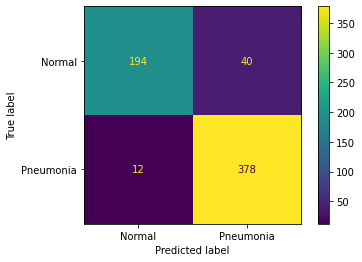

In [41]:

cm = confusion_matrix(np.array(all_labels), np.array(all_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Normal','Pneumonia'])
disp.plot()


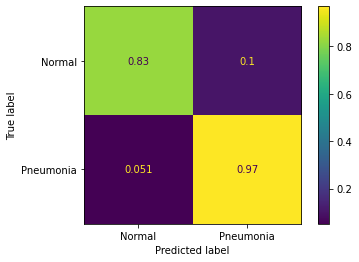

In [42]:
C = cm / cm.astype(float).sum(axis=1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=C,display_labels=['Normal','Pneumonia'])

disp1.plot()


In [ ]:
%%time
models_list0 = dir_list_models(dir="best_models")
logdata_model0 = create_log_data(model=model, models_list=models_list0)

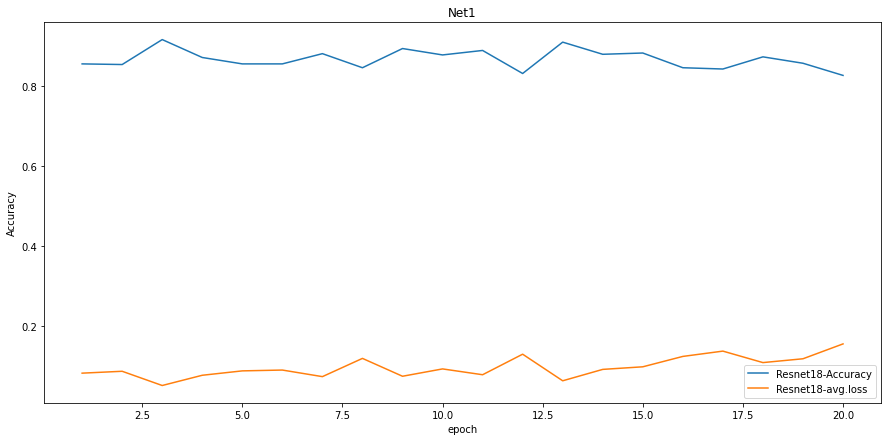

In [44]:
plt.figure(figsize=(15,7))
plt.plot(logdata_model0.epoch, logdata_model0.Accuracy/100, label='Resnet18-Accuracy')
plt.plot(logdata_model0.epoch, logdata_model0['Avg.Loss'], label='Resnet18-avg.loss')

plt.legend(); plt.xlabel('epoch'); plt.ylabel('Accuracy');  plt.title('Net1');

plt.show()

### 3rd model : Resnext

In [45]:
#importation of a pretrained resnext and change the last fully connected layer to adapt it for the classification
model2 = models.resnext50_32x4d(pretrained=True)
num_features = model2.fc.in_features
model2.fc = nn.Linear(num_features,1)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [46]:
#Training 

#boolean to know if gpu is available
use_cuda = torch.cuda.is_available()

# Create experiment folder
if not os.path.isdir("best_models_resnext"):
    os.makedirs("best_models_resnext")


In [47]:
%%time
if use_cuda: #if gpu available, we move the model to gpu
    print('Using GPU')
    model2.cuda()
    
else:
    print('Using CPU')

optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9) #We will use a SGD for optimizer

lr = 0.001
best_loss = np.inf
best_epoch = 0
for epoch in range(1, number_epoch + 1): #for each epoch
    optimizer = optim.SGD(model1.parameters(), lr, momentum=0.9) #initialise the optimizer 
    train(epoch,model2) #do the training of the epoch
    validation_loss = validation(model2) #and the validation 
    if best_loss > validation_loss:
      best_epoch = epoch
      best_loss = validation_loss
    model_file = 'best_models_resnext' + '/model_' + str(epoch) + '.pth' 
    torch.save(model2.state_dict(), model_file) #save the weight of the model
    #lr = adjust_learning_rate(epoch) #adjust the learning rate
    print('Saved model to ' + model_file )
print('best epoch : {}'.format(best_epoch))

Using GPU
Train Epoch: 1 [0/5216 (0%)]	Loss: 0.665695
Train Epoch: 1 [1600/5216 (31%)]	Loss: 0.648211
Train Epoch: 1 [3200/5216 (61%)]	Loss: 0.667541
Train Epoch: 1 [4800/5216 (92%)]	Loss: 0.641150

Validation set: Average loss: 0.0430, Accuracy: 8/16 (50%)
Saved model to best_models_resnext/model_1.pth
Train Epoch: 2 [0/5216 (0%)]	Loss: 0.684187
Train Epoch: 2 [1600/5216 (31%)]	Loss: 0.670338
Train Epoch: 2 [3200/5216 (61%)]	Loss: 0.684357
Train Epoch: 2 [4800/5216 (92%)]	Loss: 0.602730

Validation set: Average loss: 0.0430, Accuracy: 8/16 (50%)
Saved model to best_models_resnext/model_2.pth
Train Epoch: 3 [0/5216 (0%)]	Loss: 0.661137
Train Epoch: 3 [1600/5216 (31%)]	Loss: 0.644650
Train Epoch: 3 [3200/5216 (61%)]	Loss: 0.638605
Train Epoch: 3 [4800/5216 (92%)]	Loss: 0.682644

Validation set: Average loss: 0.0430, Accuracy: 8/16 (50%)
Saved model to best_models_resnext/model_3.pth
Train Epoch: 4 [0/5216 (0%)]	Loss: 0.678734
Train Epoch: 4 [1600/5216 (31%)]	Loss: 0.646560
Train Epoch: 

In [48]:
#Loading our best model from resnext
weight_path_model3 = "best_models_resnext/model_{}.pth".format(best_epoch) #put the pass of the weight
state_dict2 = torch.load(weight_path_model3)
model2.load_state_dict(state_dict2)

<All keys matched successfully>

In [49]:
use_cuda = torch.cuda.is_available()
if use_cuda: #if gpu available, we move the model to gpu
    print('Using GPU')
    model2.cuda()

model2.eval()
test_loss = 0
correct = 0
all_pred = []
all_labels = []
for data, target in tqdm(test_loader): #for each data target in the data loader
    if use_cuda: #if gpu is available, we move the data and target to gpu
        data, target = data.cuda(), target.cuda()
    target = target.reshape(-1,1)
    data = data.float()
    target = target.float()
    output = model2(data) 
    # sum up batch loss
    criterion = torch.nn.BCEWithLogitsLoss(weight=None,reduction='mean')
    test_loss += criterion(output, target).data.item() #compute the loss
    # get the index of the max log-probability
    correct += np.array(((1 * (output>0) == target)).cpu()).sum() #add +1 if the prediction is correct otherwise 0
    all_pred += list((1 * (output>0).cpu().numpy()).reshape(-1))
    all_labels += list((target.cpu().numpy()).reshape(-1))
test_loss /= len(test_loader.dataset) #calculate the loss
#print the loss and the precision of the test set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Using GPU


  0%|          | 0/125 [00:00<?, ?it/s]


Test set: Average loss: 0.1351, Accuracy: 390/624 (62%)


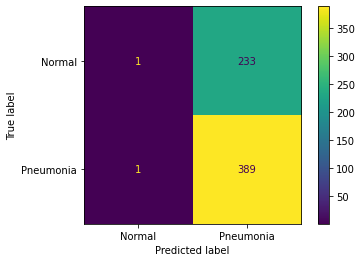

In [50]:
cm3 = confusion_matrix(np.array(all_labels), np.array(all_pred))
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm3,display_labels=['Normal','Pneumonia'])
disp4.plot()

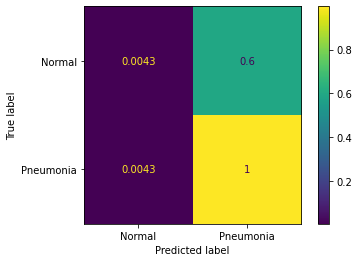

In [51]:
C3 = cm3 / cm3.astype(float).sum(axis=1)
disp5 = ConfusionMatrixDisplay(confusion_matrix=C3,display_labels=['Normal','Pneumonia'])

disp5.plot()

In [ ]:
%%time
models_list2 = dir_list_models(dir="best_models_resnext")
logdata_model2 = create_log_data(model=model2, models_list=models_list2)

### Comparing the models graphically

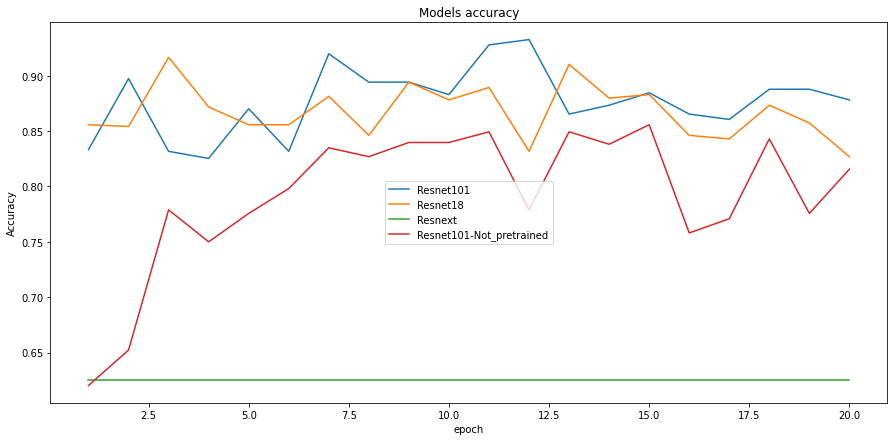

In [53]:
plt.figure(figsize=(15,7))
plt.plot(logdata_model1.epoch, logdata_model1.Accuracy/100, label='Resnet101')
plt.plot(logdata_model0.epoch, logdata_model0.Accuracy/100, label='Resnet18')
plt.plot(logdata_model2.epoch, logdata_model2.Accuracy/100, label='Resnext')
plt.plot(logdata_model4.epoch, logdata_model4.Accuracy/100, label='Resnet101-Not_pretrained')


# plt.plot(log_data.epoch, log_data.validate_accuracy, label='validation')
# plt.plot(log_data.epoch, test_accuracy1*np.ones(log_data1.epoch.shape), label=f'test: {test_accuracy1*100:2.2f}%')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('Accuracy');  plt.title('Models accuracy');

plt.show()

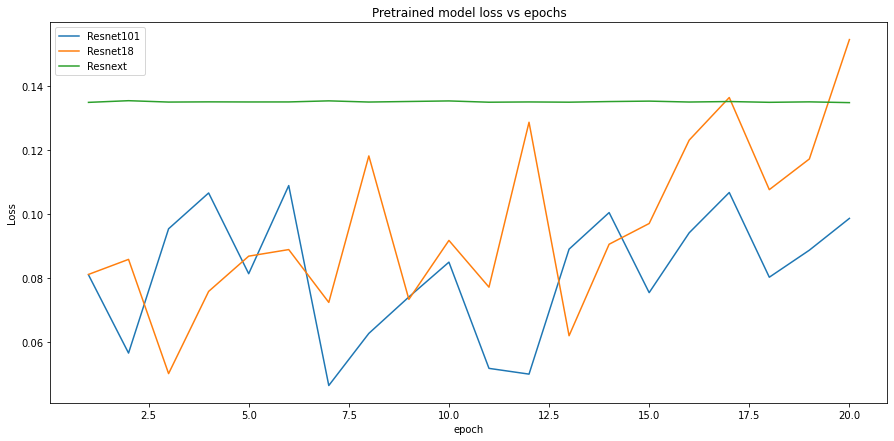

In [54]:
#plt.plot(logdata_model0.epoch, logdata_model0['Avg.Loss'], label='Resnet18-avg.loss')


plt.figure(figsize=(15,7))
plt.plot(logdata_model1.epoch, logdata_model1['Avg.Loss'], label='Resnet101')
plt.plot(logdata_model0.epoch, logdata_model0['Avg.Loss'], label='Resnet18')
plt.plot(logdata_model2.epoch, logdata_model2['Avg.Loss'], label='Resnext')
#plt.plot(logdata_model4.epoch, logdata_model4['Avg.Loss'], label='Resnet101-Not_pretrained')


# plt.plot(log_data.epoch, log_data.validate_accuracy, label='validation')
# plt.plot(log_data.epoch, test_accuracy1*np.ones(log_data1.epoch.shape), label=f'test: {test_accuracy1*100:2.2f}%')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('Loss');  plt.title('Pretrained model loss vs epochs');

plt.show()

### Evaluating our results

Lets take one batch of our test set

In [55]:
data, target = next(iter(test_loader))

And save the prediction and the ground truth for this batch

In [56]:
if use_cuda: #if gpu is available, we move the data and target to gpu
    data, target = data.cuda(), target.cuda()
target = target.reshape(-1,1)
data = data.float()
target = target.float()
output = model1(data)

In [57]:
pred = 1 * (output > 0).cpu().numpy()

In [58]:
y_target = target.cpu().numpy()

In [59]:
data.shape

torch.Size([5, 3, 256, 256])

Now we plot all the images of this batch with the prediction of the model and the ground truth.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


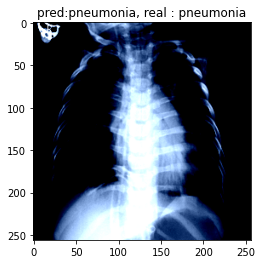

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


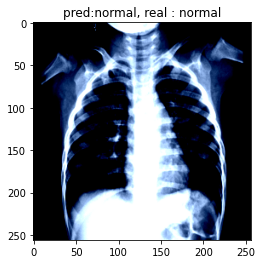

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


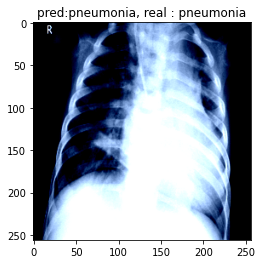

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


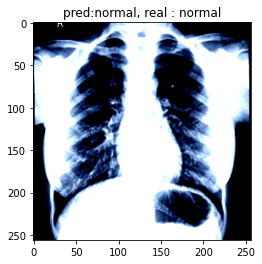

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


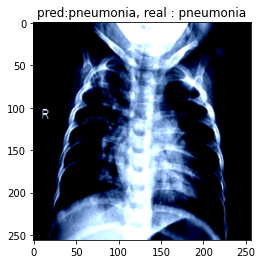

In [60]:
for i in range(len(data)):
  plt.imshow(np.moveaxis(data[i].cpu().numpy(), 0, -1))
  plt.title('pred:{}, real : {}'.format('normal' if pred[i][0] == 0 else 'pneumonia','normal' if y_target[i][0] == 0 else 'pneumonia'))
  plt.show()

# A nice bonus : Gradcam!
https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353

Gradcam helps us understand better how our model make his prediction and make them observable by human eye. 

In [61]:
class ResNet_CAM(nn.Module):
    def __init__(self, net, layer_k):
        super(ResNet_CAM, self).__init__()
        self.resnet = net
        convs = nn.Sequential(*list(net.children())[:-1])
        self.first_part_conv = convs[:layer_k]
        self.second_part_conv = convs[layer_k:]
        self.linear = nn.Sequential(*list(net.children())[-1:])
        
    def forward(self, x):
        x = self.first_part_conv(x)
        x.register_hook(self.activations_hook)
        x = self.second_part_conv(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
        x = x.view((1, -1))
        x = self.linear(x)
        return x
    
    def activations_hook(self, grad):
        self.gradients = grad
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.first_part_conv(x)

In [62]:
gradcam = ResNet_CAM(model1,4)

# set the evaluation mode
gradcam.eval()

print('gradcam model created')


gradcam model created


In [63]:
def get_grad_cam(net, img):
    net.eval()
    pred = net(img)
    (pred).backward()
    gradients = net.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = net.get_activations(img).detach()
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap /= torch.max(heatmap)
    
    return heatmap

In [64]:
import cv2

In [65]:
def superimpose_heatmap(heatmap, img):
    img = img.cpu()
    heatmap = heatmap.cpu()
    resized_heatmap = cv2.resize(heatmap.numpy(), (img.shape[2], img.shape[3]))
    resized_heatmap = np.uint8(255 * resized_heatmap)
    resized_heatmap = cv2.applyColorMap(resized_heatmap, cv2.COLORMAP_JET)
    superimposed_img = torch.Tensor(cv2.cvtColor(resized_heatmap, cv2.COLOR_BGR2RGB)) * 0.006 + img[0].permute(1,2,0)
    
    return superimposed_img


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


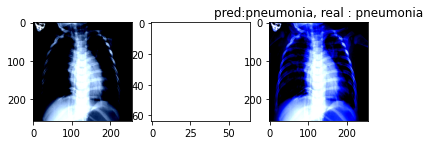

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


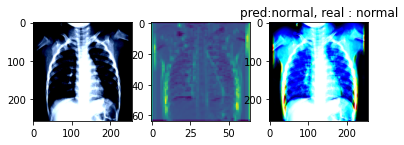

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


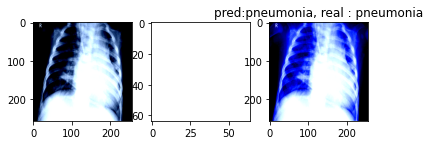

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


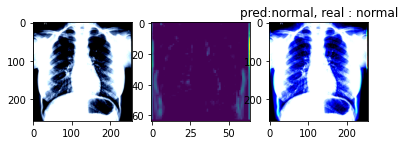

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


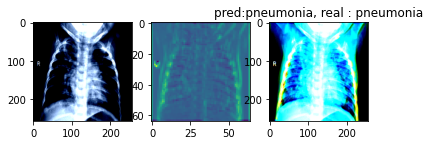

In [66]:
for i in range(len(data)):
    fig=plt.figure()
    
    fig.add_subplot(1,3,1)
    img = data[i:i+1]
    plt.imshow(img[0].cpu().permute(1,2,0))
    fig.add_subplot(1,3,2)
    heatmap = get_grad_cam(gradcam, img)
    plt.imshow(heatmap)
    fig.add_subplot(1,3,3)
    final = superimpose_heatmap(heatmap, img)
    plt.imshow(final)
    plt.title('pred:{}, real : {}'.format('normal' if pred[i][0] == 0 else 'pneumonia','normal' if y_target[i][0] == 0 else 'pneumonia'))
    plt.show()

## Conclusions

As we observed, our model performed well ~89%. We think we can generalised the used of DL to predict pneumonia in hospitals. At the beginning, to compare the model diagnosis with the doctors diagnosis. For the long-term, we think this model can be generalised to other diseases.